In [1]:
import pandas as pd
import numpy as np

import json
import os


import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
from plotly.io import show
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from timple.timedelta import strftimedelta
from datetime import timedelta
import datetime
import fastf1
import fastf1.plotting
from fastf1.core import Laps
from fastf1.ergast import Ergast

import statistics as st
from time import sleep

import warnings
warnings.filterwarnings("ignore")



# FUNCIONES PARA TODO

In [5]:
#generate a dictionary that relates driverId to driverRef

def make_driver_dict():
    drivers_df = pd.read_csv('data/kaggle/drivers.csv')
    drivers_df = drivers_df[['driverId', 'code', 'driverRef']]

    drivers_df['code'] = drivers_df.apply(lambda row: row['driverRef'] if row['code'] == '\\N' else row['code'], axis=1)
    drivers_dict = dict(zip(drivers_df['driverId'], drivers_df['code']))

    return drivers_dict

#generate a dictionary that relates constructorId to constructorRef

def make_constructor_dict():
    teams_df = pd.read_csv('data/kaggle/constructors.csv')
    teams_df = teams_df[['constructorId', 'name', 'constructorRef']]

    teams_df['name'] = teams_df.apply(lambda row: row['constructorRef'] if row['name'] == '\\N' else row['name'], axis=1)
    teams_dict = dict(zip(teams_df['constructorId'], teams_df['name']))

    return teams_dict

#
def make_races_dict(year):
    races_df = pd.read_csv('data/kaggle/races.csv')
    races_in_year = races_df[races_df['year'] == year]
    races_dict = dict(zip(races_in_year['raceId'], races_in_year['name']))
    return races_dict

# TEMPORADA

## Points Progresion plot

### Drivers

- Coger los nombres de los pilotos (o abreviaciones)
- Hacer el grafico bien (como el otro)

#### Heatmap

In [4]:
year = 2007

In [5]:

### Load the data of the results of a given year

# Load the CSV files into pandas dataframes
results_df = pd.read_csv('data/kaggle/results.csv')
sprints_results_df = pd.read_csv('data/kaggle/sprint_results.csv')
races_df = pd.read_csv('data/kaggle/races.csv')

# select the columns raceId, driverId, constructorId and points from results_df
results_df = results_df[['raceId', 'driverId', 'constructorId', 'points']]
sprints_results_df = sprints_results_df[['raceId', 'driverId', 'constructorId', 'points']]

#given the year, select from results_df all the races that happened in that year 
races_in_year = races_df[races_df['year'] == year]['raceId']
results_in_year = results_df[results_df['raceId'].isin(races_in_year)]
sprints_in_year = sprints_results_df[sprints_results_df['raceId'].isin(races_in_year)]

#sum the points of the sprint results (sprint_in_year) to the points in the results_in_year given the same raceId, driverId and constructorId
results_in_year = pd.concat([results_in_year, sprints_in_year], ignore_index=True)
results_in_year = results_in_year.groupby(['raceId', 'driverId', 'constructorId'], as_index=False)['points'].sum()


#create a column for accumulated points for each driver in the season
results_in_year['accumulated_points'] = results_in_year.groupby('driverId')['points'].cumsum()

results_in_year = results_in_year.merge(races_df[['raceId', 'name']], on='raceId', how='left')

#create a list with the order of the races in the season
races_order = results_in_year['name'].unique()

#make a dictionary with the driverId as key and the abbreviation of the driver as value
drivers_df = pd.read_csv('data/kaggle/drivers.csv')
drivers_df = drivers_df[['driverId', 'code', 'driverRef']]

drivers_df['code'] = drivers_df.apply(lambda row: row['driverRef'] if row['code'] == '\\N' else row['code'], axis=1)
drivers_dict = dict(zip(drivers_df['driverId'], drivers_df['code']))


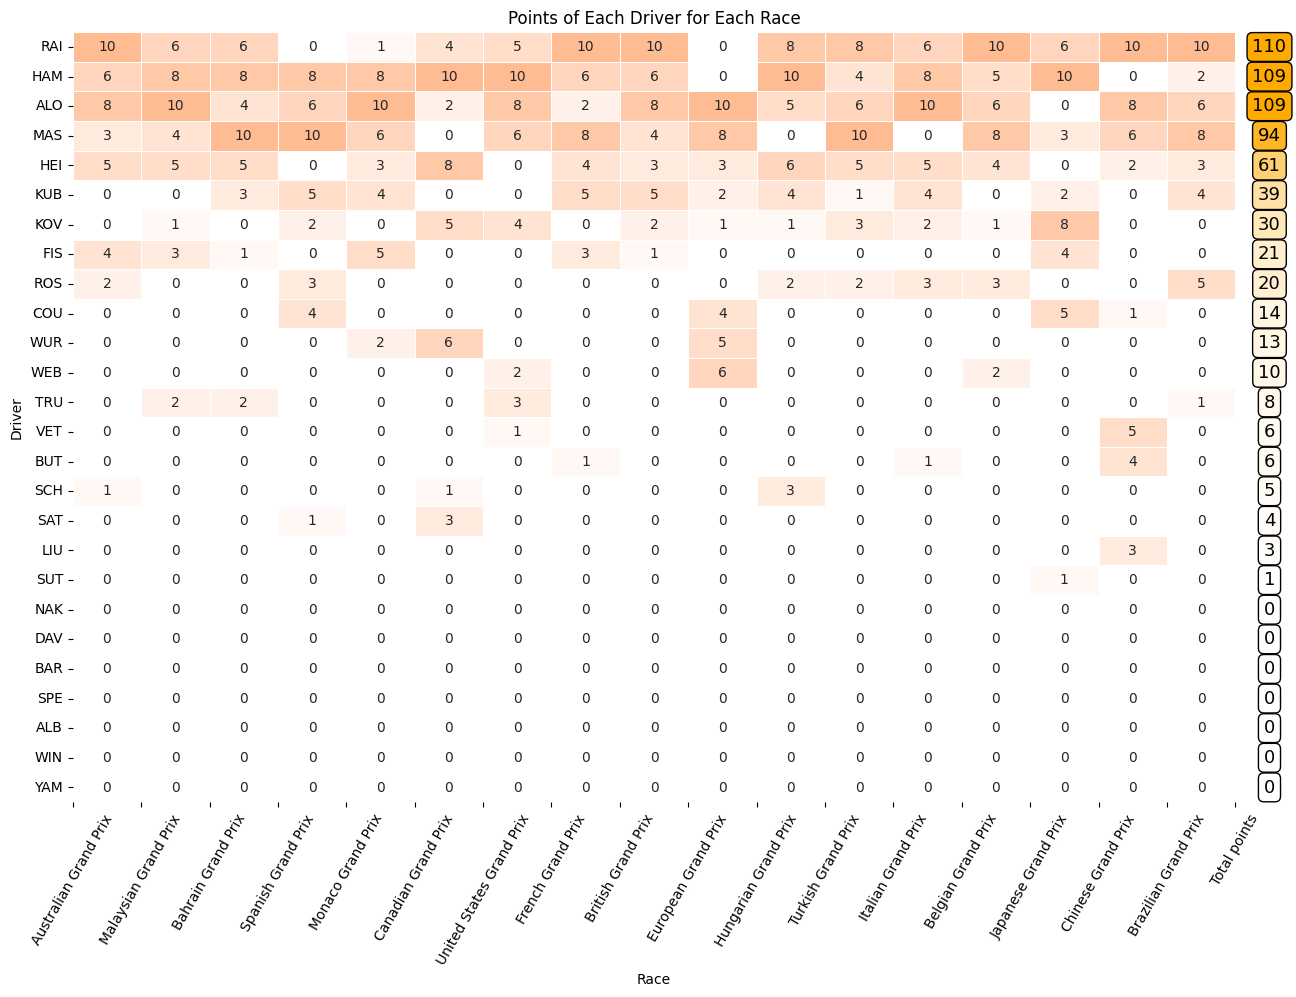

In [6]:


# Define a custom colormap
colors_race = ['#ffffff', '#ffbb92']
colors_total = ['#ffffff', '#ffaa00']
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'custom_gradient'
custom_cmap_race = LinearSegmentedColormap.from_list(cmap_name, colors_race, N=n_bins)
custom_cmap_total = LinearSegmentedColormap.from_list(cmap_name, colors_total, N=n_bins)

# Pivot the results_in_year dataframe to create a matrix of points for each driver and race
heatmap_data = results_in_year.pivot(index='driverId', columns='name', values='points').fillna(0)
heatmap_data = heatmap_data.rename(columns={'accumulated_points': 'Total points'})
max_points = heatmap_data.max().max()   
# Create a column for accumulated points for each driver in the heatmap_data
heatmap_data['Total points'] = heatmap_data.sum(axis=1)

# Sort the heatmap_data dataframe by 'Total points' in descending order
heatmap_data = heatmap_data.sort_values(by='Total points', ascending=False)

# Specify vmin and vmax for the color gradient
vmin = 0  # Minimum value for the color scale
vmax = max_points  # Maximum value for the color scale

# Extract the 'Total points' column for special styling
special_column = heatmap_data['Total points']
heatmap_data = heatmap_data.drop(columns=['Total points'])

# Order the columns of heatmap_data according to the order of the elements of races_order
heatmap_data = heatmap_data[races_order]
# Create the heatmap for the main data
plt.figure(figsize=(15, 10))
ax = sns.heatmap(
    heatmap_data.rename(index=drivers_dict), 
    annot=True, 
    fmt=".0f", 
    cmap=custom_cmap_race, 
    linewidths=.5, 
    vmin=vmin,  
    vmax=vmax, 
    cbar=False
)

# Overlay the 'Total points' column with a color gradient
norm = plt.Normalize(vmin=special_column.min(), vmax=special_column.max())
for i, value in enumerate(special_column):
    ax.text(
        len(heatmap_data.columns) + 0.5,  # Position on the right side of the heatmap
        i + 0.5,  # Center the text in the cell
        f"{value:.0f}",  # Format the value
        ha='center',
        va='center',
        color='black',
        fontsize=13,
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor=custom_cmap_total(norm(value)))  # Color gradient
    )

# Add the column name for 'Total points' in the x-axis
ax.set_xticks(list(range(len(heatmap_data.columns) + 1)))
ax.set_xticklabels(list(heatmap_data.columns) + ['Total points'], rotation=60)
plt.yticks(rotation=0)

# Adjust the title and labels
plt.title('Points of Each Driver for Each Race')
plt.xlabel('Race')
plt.ylabel('Driver')

# Show the plot
plt.show()


#### Scatter plot

In [7]:
results_in_year['driver_code'] = results_in_year['driverId'].map(drivers_dict)

fig = px.line(results_in_year, x='name', y='accumulated_points', color='driver_code', 
              labels={'driver_code': 'Driver', 'name': 'Race', 'accumulated_points': 'Accumulated Points', 'points': 'Points'},
              title='Accumulated Points of Each Driver Throughout the Year',
              hover_data={'points': True})

fig.update_layout(xaxis=dict(tickangle=-45), template='plotly_white')
fig.update_layout(width=1200, height=800)
fig.show()


### Teams

#### Heatmap

In [8]:
year = 2007

In [9]:

### Load the data of the results of a given year
# Load the CSV files into pandas dataframes
constructors_results_df = pd.read_csv('data/kaggle/results.csv')
sprints_results_df = pd.read_csv('data/kaggle/sprint_results.csv')
races_df = pd.read_csv('data/kaggle/races.csv')

# Select the columns raceId, driverId, constructorId and points from results_df
results_df = results_df[['raceId', 'driverId', 'constructorId', 'points']]
sprints_results_df = sprints_results_df[['raceId', 'driverId', 'constructorId', 'points']]

# Given the year, select from results_df all the races that happened in that year 
races_in_year = races_df[races_df['year'] == year]['raceId']
results_in_year = results_df[results_df['raceId'].isin(races_in_year)]
sprints_in_year = sprints_results_df[sprints_results_df['raceId'].isin(races_in_year)]

# Sum the points of the sprint results (sprint_in_year) to the points in the results_in_year given the same raceId, driverId and constructorId
results_in_year = pd.concat([results_in_year, sprints_in_year], ignore_index=True)
results_in_year = results_in_year.groupby(['raceId', 'driverId', 'constructorId'], as_index=False)['points'].sum()

# Create a column for accumulated points for each driver in the season
results_in_year['accumulated_points'] = results_in_year.groupby('driverId')['points'].cumsum()

results_in_year = results_in_year.merge(races_df[['raceId', 'name']], on='raceId', how='left')

# Create a list with the order of the races in the season
races_order = results_in_year['name'].unique()

#make a dictionary with the constructorId as key and the name of the team as value
constructors_df = pd.read_csv('data/kaggle/constructors.csv')
constructors_df = constructors_df[['constructorId', 'name']]
constructors_df = constructors_df.rename(columns={'name': 'constructors_name'})

# Group by raceId and constructorId to get team points
team_points_df = results_in_year.groupby(['raceId', 'constructorId'], as_index=False)['points'].sum()
team_points_df = team_points_df.merge(races_df[['raceId', 'name']], on='raceId', how='left')
team_points_df = team_points_df.merge(constructors_df, on='constructorId', how='left')

team_points_df['accumulated_points'] = team_points_df.groupby('constructorId')['points'].cumsum()
constructors_df = constructors_df.rename(columns={'accumulated_points': 'Total points'})



In [13]:
team_points_df


,raceId,constructorId,points,name,constructors_name,accumulated_points
0,36,1,14.0,Australian Grand Prix,McLaren,14.0
1,36,2,5.0,Australian Grand Prix,BMW Sauber,5.0
2,36,3,2.0,Australian Grand Prix,Williams,2.0
3,36,4,4.0,Australian Grand Prix,Renault,4.0
4,36,5,0.0,Australian Grand Prix,Toro Rosso,0.0
...,...,...,...,...,...,...
182,52,7,1.0,Brazilian Grand Prix,Toyota,13.0
183,52,8,0.0,Brazilian Grand Prix,Super Aguri,4.0
184,52,9,0.0,Brazilian Grand Prix,Red Bull,24.0
185,52,11,0.0,Brazilian Grand Prix,Honda,6.0


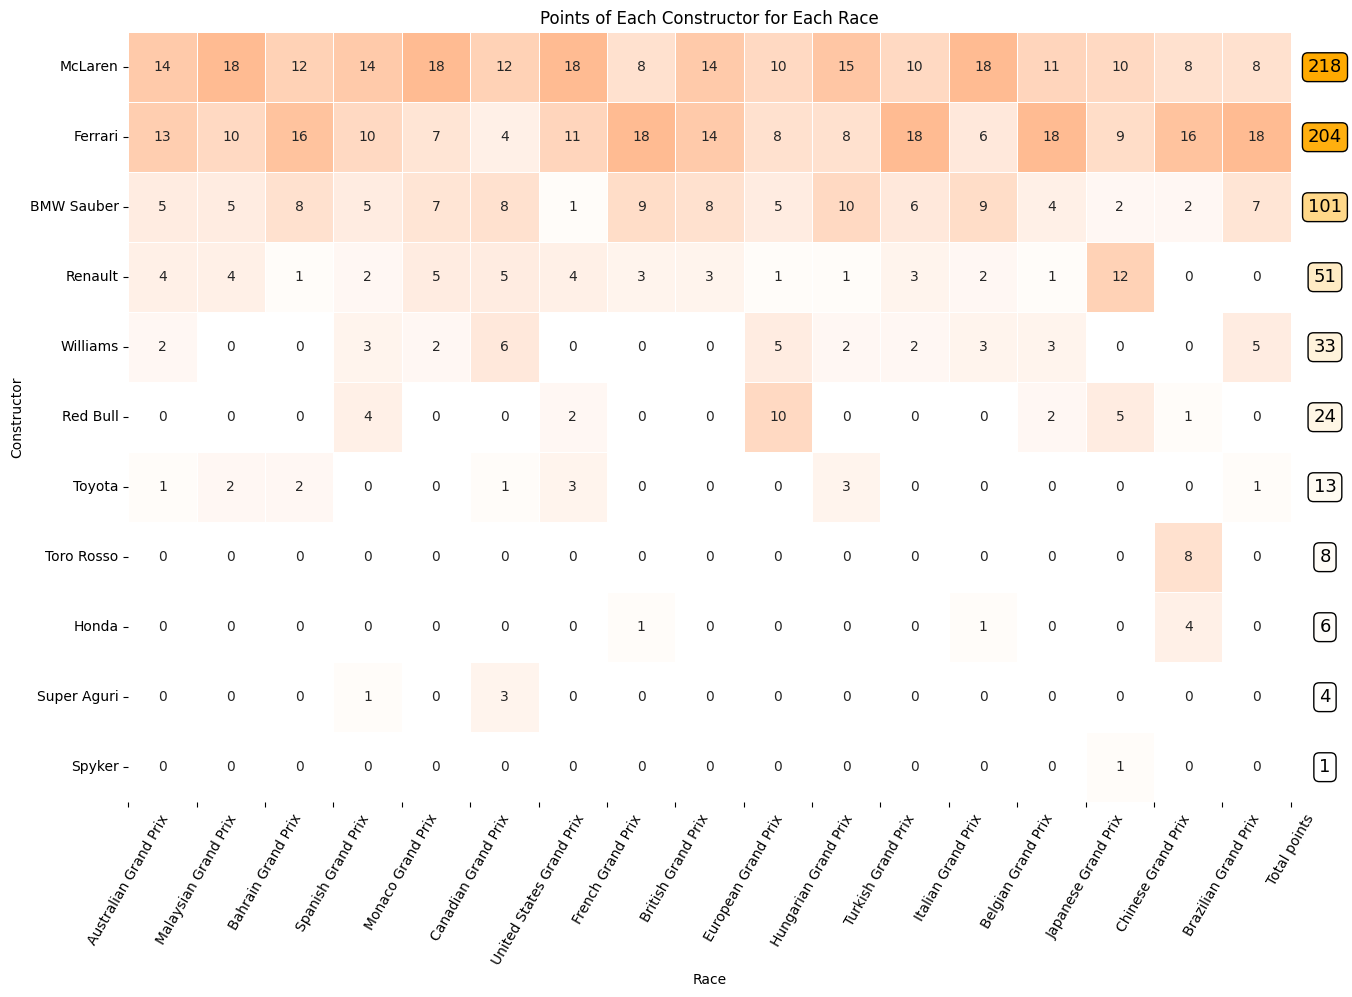

In [10]:
# Define a custom colormap
colors_race = ['#ffffff', '#ffbb92']
colors_total = ['#ffffff', '#ffaa00']
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'custom_gradient'
custom_cmap_race = LinearSegmentedColormap.from_list(cmap_name, colors_race, N=n_bins)
custom_cmap_total = LinearSegmentedColormap.from_list(cmap_name, colors_total, N=n_bins)

# Pivot the team_points_df dataframe to create a matrix of points for each constructor and race
heatmap_data = team_points_df.pivot(index='constructors_name', columns='name', values='points').fillna(0)
heatmap_data = heatmap_data.rename(columns={'accumulated_points': 'Total points'})
max_points = heatmap_data.max().max()   
# Create a column for accumulated points for each constructor in the heatmap_data
heatmap_data['Total points'] = heatmap_data.sum(axis=1)

# Sort the heatmap_data dataframe by 'Total points' in descending order
heatmap_data = heatmap_data.sort_values(by='Total points', ascending=False)

# Specify vmin and vmax for the color gradient
vmin = 0  # Minimum value for the color scale
vmax = max_points  # Maximum value for the color scale

# Extract the 'Total points' column for special styling
special_column = heatmap_data['Total points']
heatmap_data = heatmap_data.drop(columns=['Total points'])

# Order the columns of heatmap_data according to the order of the elements of races_order
heatmap_data = heatmap_data[races_order]
# Create the heatmap for the main data
plt.figure(figsize=(15, 10))
ax = sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".0f", 
    cmap=custom_cmap_race, 
    linewidths=.5, 
    vmin=vmin,  
    vmax=vmax, 
    cbar=False
)

# Overlay the 'Total points' column with a color gradient
norm = plt.Normalize(vmin=special_column.min(), vmax=special_column.max())
for i, value in enumerate(special_column):
    ax.text(
        len(heatmap_data.columns) + 0.5,  # Position on the right side of the heatmap
        i + 0.5,  # Center the text in the cell
        f"{value:.0f}",  # Format the value
        ha='center',
        va='center',
        color='black',
        fontsize=13,
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor=custom_cmap_total(norm(value)))  # Color gradient
    )

# Add the column name for 'Total points' in the x-axis
ax.set_xticks(list(range(len(heatmap_data.columns) + 1)))
ax.set_xticklabels(list(heatmap_data.columns) + ['Total points'], rotation=60)
plt.yticks(rotation=0)

# Adjust the title and labels
plt.title('Points of Each Constructor for Each Race')
plt.xlabel('Race')
plt.ylabel('Constructor')

# Show the plot
plt.show()

#### Scatter plot

In [14]:
# Create a dictionary with the constructorId as key and the name of the team as value
constructors_dict = dict(zip(constructors_df['constructorId'], constructors_df['constructors_name']))

team_points_df['constructor_name'] = team_points_df['constructorId'].map(constructors_dict)

fig = px.line(team_points_df, x='name', y='accumulated_points', color='constructor_name', 
              labels={'constructor_name': 'Constructor', 'name': 'Race', 'accumulated_points': 'Accumulated Points', 'points': 'Points'},
              title='Accumulated Points of Each Constructor Throughout the Year',
              hover_data={'points': True})

fig.update_layout(xaxis=dict(tickangle=-45), template='plotly_white')
fig.update_layout(width=1200, height=800)
fig.show()

## Pace performance

### Drivers

FALTA:
- Color
- Quitar outliers (no completan X% de la carrera)

In [4]:
year = 2023

In [54]:

laps_df = pd.read_csv('data/kaggle/lap_times.csv')
races_df = pd.read_csv('data/kaggle/races.csv')
drivers_df = pd.read_csv('data/kaggle/drivers.csv')

#create the dictionary that relates driverId to driverRef
drivers_dict = make_driver_dict()
races_dict = make_races_dict(year)

#given the year, select from laps_df all the laps that happened in that year 
races_in_year = races_df[races_df['year'] == year]
laps_in_year = laps_df[laps_df['raceId'].isin(races_in_year['raceId'])]

races_id_unique = races_in_year['raceId'].unique()
races_name_unique = races_in_year['name'].unique()



drivers_id_unique = laps_in_year['driverId'].unique()
drivers_name_unique = [drivers_dict[driver] for driver in drivers_id_unique]
# races_name_unique = races_df['name'].unique()

#create a dataframe to store the mean difference for each driver in each race
pace_df = pd.DataFrame(columns=races_name_unique, index=drivers_name_unique)

#for every race
for id in races_id_unique:
    drivers = laps_in_year[laps_in_year['raceId'] == id]['driverId'].unique()
    laps = laps_in_year[laps_in_year['raceId'] == id]['lap'].unique()
    n_laps = len(laps)
    # Create a dataframe to store lap times for each driver
    lap_times_df = pd.DataFrame(index=drivers, columns=range(1, n_laps + 1))

    # Populate the dataframe with lap times
    for driver in drivers:
        driver_laps = laps_in_year[(laps_in_year['raceId'] == id) & (laps_in_year['driverId'] == driver)]
        for lap in laps:
            lap_time = driver_laps[driver_laps['lap'] == lap]['milliseconds'].values
            if lap_time.size > 0:
                lap_times_df.at[driver, lap] = lap_time[0]
    # Apply timedelta to each value of lap_times_df
    lap_times_df = lap_times_df.applymap(lambda x: timedelta(milliseconds=int(x)).total_seconds() if pd.notnull(x) else x)

    # Create a dictionary with the mean lap time for each lap of the race
    mean_lap_times = {}
    for lap in laps:
        mean_lap_time = lap_times_df[lap].mean()
        mean_lap_times[int(lap)] = mean_lap_time
    
    diff_times_df = lap_times_df.copy()
    
    #calculate the difference between the lap time of each driver and the mean time
    for lap in laps:
        diff_times_df[lap] = diff_times_df[lap] - mean_lap_times[lap]
        
    #create a dictionary that stores, for each driver (key) the mean difference of the lap times (value)
    mean_diff_times = {}
    for driver in drivers:
        mean_diff_time = diff_times_df.loc[driver].mean()
        mean_diff_times[driver] = mean_diff_time

    
    #add the mean difference of the lap times for each driver in the pace_df dataframe
    for driver, diff in mean_diff_times.items(): 
        pace_df.loc[drivers_dict[driver], races_dict[id]] = diff
    




In [53]:
# Ensure all columns are of the same type
pace_df = pace_df.T
pace_df = pace_df.apply(pd.to_numeric, errors='coerce')
fig = px.line(pace_df, x=pace_df.index, y=pace_df.columns, line_shape='linear',
                labels={'value': 'Time Difference (seconds)', 'index': 'Circuits'}, 
                title=f'Time Difference Progression Compared to Average Season {year}',
                markers=True)

fig.update_layout(xaxis_title='Circuits', yaxis_title='Time Difference (seconds)', 
                    legend_title='Driver', xaxis=dict(tickangle=-60), template='plotly_white')

fig.update_yaxes(autorange='reversed')
# for driver, style in driver_styles.items():
#     fig.update_traces(selector=dict(name=driver), line=dict(color=style['color'], dash=style['line'])) 
fig.update_layout(width=1200, height=800)

### Teams

Para hacer el de equipo, hay que relacionar al piloto con el equipo a traves de results.csv

In [7]:
year = 2023

In [8]:
laps_df = pd.read_csv('data/kaggle/lap_times.csv')
races_df = pd.read_csv('data/kaggle/races.csv')
constructors_df = pd.read_csv('data/kaggle/constructors.csv')

#create the dictionary that relates constructorId to constructorRef
constructors_dict = make_constructor_dict()
races_dict = make_races_dict(year)

#given the year, select from laps_df all the laps that happened in that year 
races_in_year = races_df[races_df['year'] == year]
laps_in_year = laps_df[laps_df['raceId'].isin(races_in_year['raceId'])]

races_id_unique = races_in_year['raceId'].unique()
races_name_unique = races_in_year['name'].unique()



constructors_id_unique = laps_in_year['constructorId'].unique()
constructors_name_unique = [constructors_dict[constructor] for constructor in constructors_id_unique]
# races_name_unique = races_df['name'].unique()

#create a dataframe to store the mean difference for each constructor in each race
pace_df = pd.DataFrame(columns=races_name_unique, index=constructors_name_unique)

#for every race
for id in races_id_unique:
    constructors = laps_in_year[laps_in_year['raceId'] == id]['constructorId'].unique()
    laps = laps_in_year[laps_in_year['raceId'] == id]['lap'].unique()
    n_laps = len(laps)
    # Create a dataframe to store lap times for each constructor
    lap_times_df = pd.DataFrame(index=constructors, columns=range(1, n_laps + 1))

    # Populate the dataframe with lap times
    for constructor in constructors:
        constructor_laps = laps_in_year[(laps_in_year['raceId'] == id) & (laps_in_year['constructorId'] == constructor)]
        for lap in laps:
            lap_time = constructor_laps[constructor_laps['lap'] == lap]['milliseconds'].values
            if lap_time.size > 0:
                lap_times_df.at[constructor, lap] = lap_time[0]
    # Apply timedelta to each value of lap_times_df
    lap_times_df = lap_times_df.applymap(lambda x: timedelta(milliseconds=int(x)).total_seconds() if pd.notnull(x) else x)

    # Create a dictionary with the mean lap time for each lap of the race
    mean_lap_times = {}
    for lap in laps:
        mean_lap_time = lap_times_df[lap].mean()
        mean_lap_times[int(lap)] = mean_lap_time
    
    diff_times_df = lap_times_df.copy()
    
    #calculate the difference between the lap time of each constructor and the mean time
    for lap in laps:
        diff_times_df[lap] = diff_times_df[lap] - mean_lap_times[lap]
        
    #create a dictionary that stores, for each constructor (key) the mean difference of the lap times (value)
    mean_diff_times = {}
    for constructor in constructors:
        mean_diff_time = diff_times_df.loc[constructor].mean()
        mean_diff_times[constructor] = mean_diff_time

    
    #add the mean difference of the lap times for each constructor in the pace_df dataframe
    for constructor, diff in mean_diff_times.items(): 
        pace_df.loc[constructors_dict[constructor], races_dict[id]] = diff
    




KeyError: 'constructorId'

# POR AQUI

vale ya tengo de cada carrera el DF con las diferencias de tiempo de cada piloto con respecto a la media

Ahora quedaria sacar al media de cada piloto para esa carrera, y hacer el DF gordo con esos valores para cada carrera y cada piloto

Luego ya seria unir con la funcion que ya tengo hecha para representar

In [ ]:

### Load the data of the results of a given year

# Load the CSV files into pandas dataframes
results_df = pd.read_csv('data/kaggle/results.csv')
sprints_results_df = pd.read_csv('data/kaggle/sprint_results.csv')
races_df = pd.read_csv('data/kaggle/races.csv')

# select the columns raceId, driverId, constructorId and points from results_df
results_df = results_df[['raceId', 'driverId', 'constructorId', 'points']]
sprints_results_df = sprints_results_df[['raceId', 'driverId', 'constructorId', 'points']]

#given the year, select from results_df all the races that happened in that year 
races_in_year = races_df[races_df['year'] == year]['raceId']
results_in_year = results_df[results_df['raceId'].isin(races_in_year)]
sprints_in_year = sprints_results_df[sprints_results_df['raceId'].isin(races_in_year)]

#sum the points of the sprint results (sprint_in_year) to the points in the results_in_year given the same raceId, driverId and constructorId
results_in_year = pd.concat([results_in_year, sprints_in_year], ignore_index=True)
results_in_year = results_in_year.groupby(['raceId', 'driverId', 'constructorId'], as_index=False)['points'].sum()


#create a column for accumulated points for each driver in the season
results_in_year['accumulated_points'] = results_in_year.groupby('driverId')['points'].cumsum()

results_in_year = results_in_year.merge(races_df[['raceId', 'name']], on='raceId', how='left')

#create a list with the order of the races in the season
races_order = results_in_year['name'].unique()

#make a dictionary with the driverId as key and the abbreviation of the driver as value
drivers_df = pd.read_csv('data/kaggle/drivers.csv')
drivers_df = drivers_df[['driverId', 'code', 'driverRef']]

drivers_df['code'] = drivers_df.apply(lambda row: row['driverRef'] if row['code'] == '\\N' else row['code'], axis=1)
drivers_dict = dict(zip(drivers_df['driverId'], drivers_df['code']))


In [7]:
results_in_year

,raceId,driverId,constructorId,points,accumulated_points,name
0,1098,1,131,10.0,10.0,Bahrain Grand Prix
1,1098,4,117,15.0,15.0,Bahrain Grand Prix
2,1098,807,210,0.0,0.0,Bahrain Grand Prix
3,1098,815,9,18.0,18.0,Bahrain Grand Prix
4,1098,822,51,4.0,4.0,Bahrain Grand Prix
...,...,...,...,...,...,...
435,1120,848,3,0.0,27.0,Abu Dhabi Grand Prix
436,1120,852,213,4.0,17.0,Abu Dhabi Grand Prix
437,1120,855,51,0.0,6.0,Abu Dhabi Grand Prix
438,1120,857,1,8.0,97.0,Abu Dhabi Grand Prix


#### mis mierdas

In [22]:
timedelta(milliseconds=92669).total_seconds()

92.669

In [20]:
from datetime import timedelta

def convertir_a_timedelta(milisegundos):
    # Convertir milisegundos a un objeto timedelta
    return timedelta(milliseconds=milisegundos)

def formatear_timedelta(tiempo):
    # Extraer minutos, segundos y milisegundos del objeto timedelta
    minutos, segundos = divmod(tiempo.total_seconds(), 60)
    milisegundos = int(tiempo.microseconds / 1000)
    # Retornar como un diccionario para un formato más estructurado (opcional)
    return {
        "minutos": int(minutos),
        "segundos": int(segundos),
        "milisegundos": milisegundos
    }

# Ejemplo de uso
milisegundos = 92669
td = convertir_a_timedelta(milisegundos)

# Trabajar con timedelta como objeto matemático
print(f"Tiempo total en segundos: {td.total_seconds()}")  # 125.34 segundos

# Convertir timedelta a un formato personalizado
formato = formatear_timedelta(td)
print(f"{formato['minutos']:02}:{formato['segundos']:02}.{formato['milisegundos']:03}")  # 02:05.340



Tiempo total en segundos: 92.669
01:32.669


In [19]:
int(tiempo)

ValueError: invalid literal for int() with base 10: '01:32.669'

### Teams